In [ ]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

import numpy as np
import pandas as pd
from tensorflow import feature_column
from tensorflow.keras.layers import Input, Concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import CategoryEncoding, TextVectorization, Embedding, Normalization, StringLookup
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import pathlib
import string
import re
import gc

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import shap
shap.initjs()

---
### Mixed Data Types

In [ ]:
dataset_url = "http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip"
csv_file = "datasets/petfinder-mini/petfinder-mini.csv"

tf.keras.utils.get_file("petfinder_mini.zip", dataset_url, extract = True, cache_dir = ".")
dataframe = pd.read_csv(csv_file)

In [ ]:
dataframe.info()

In [ ]:
dataframe["target"] = dataframe["AdoptionSpeed"] # np.where(dataframe["AdoptionSpeed"] == 4, 0, 1)
dataframe = dataframe.drop(columns = ["AdoptionSpeed", "Description"])

In [ ]:
train, test = train_test_split(dataframe, test_size = 0.2)
train, val = train_test_split(train, test_size = 0.2)

print(len(train), "train examples")
print(len(val), "validation examples")
print(len(test), "test examples")

In [ ]:
numeric = train.drop(columns = "target").select_dtypes("int64").columns.to_list()
categorical = train.drop(columns = "target").select_dtypes("object").columns.to_list()

- Type: CategoryEncoding
- Breed1: TextVectorizer -> Embedding
- Gender: CategoryEncoding
- Color1: CategoryEncoding
- Color2: CategoryEncoding
- MaturitySize: CategoryEncoding (ordinal)
- FurLength: CategoryEncoding (ordinal)
- Vaccinated: CategoryEncoding
- Sterilized: CategoryEncoding
- Health: CategoryEncoding (ordinal)

In [ ]:
ordinal = ["MaturitySize", "FurLength", "Health"]
for feature in ordinal:
    categorical.remove(feature)

In [ ]:
print(numeric)
print(ordinal)
print(categorical)

In [ ]:
train.columns

In [ ]:
features = train.drop(columns = "target").columns.to_list()
pd.get_dummies(train, columns = ["target"]).drop(columns = features).head()

In [ ]:
columns = train.columns
features = train.drop(columns = "target").columns.to_list()

X_train = train[features]
y_train = pd.get_dummies(train, columns = ["target"]).drop(columns = features)

X_val = val[features]
y_val = pd.get_dummies(val, columns = ["target"]).drop(columns = features)

X_test = test[features]
y_test = pd.get_dummies(test, columns = ["target"]).drop(columns = features)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val)).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test)).batch(64)

In [ ]:
# Use a separate preprocessing model to encode and tokenize text

def normalize(column, X):
    i = Input(shape = (1,), dtype = tf.float32, name = column)
    
    normalization = Normalization(name = f"{column}Normalization")
    ds = tf.data.Dataset.from_tensor_slices(X[column]).batch(1024)
    normalization.adapt(X[column])
    e = normalization(i)
    
    return i, e


def encode(column, X, vocab_size = 1024, sequence_length = 1):
    i = Input(shape = (1,), dtype = tf.string, name = column)

    vectorization = TextVectorization(
        standardize = "lower_and_strip_punctuation",
        split = "whitespace",
        output_mode = "int",
        max_tokens = vocab_size,
        output_sequence_length = sequence_length,
        name = f"{column}Encoding"
    )
    
    ds = tf.data.Dataset.from_tensor_slices(X[column]).batch(1024)
    vectorization.adapt(ds)
    
    e = vectorization(i)
    return i, e


preprocessing_inputs = {}
preprocessing_outputs = {}

for column in X_train.columns:
    if column in numeric:
        i, o = normalize(column, X_train)
    else:
        i, o = encode(column, X_train)

    preprocessing_inputs[column] = i
    preprocessing_outputs[column] = o

# No need to compile or fit this model, just instantiate it
preprocessor = tf.keras.Model(inputs = preprocessing_inputs, outputs = preprocessing_outputs, name = "preprocessor")

In [ ]:
tf.keras.utils.plot_model(preprocessor, rankdir = "LR", show_layer_names = True, dpi = 60)

In [ ]:
Z_train = pd.DataFrame({
    column: tensor.numpy().ravel()
    for column, tensor in preprocessor(dict(X_train)).items()
})

Z_val = pd.DataFrame({
    column: tensor.numpy().ravel()
    for column, tensor in preprocessor(dict(X_val)).items()
})

In [ ]:
def embed(column, X, vocab_size = 1024, embedding_dim = 4):
    i = Input(shape = (1,), dtype = tf.int64, name = column)
    embedding = Embedding(vocab_size, embedding_dim, name = f"{column}Embedding")(i)
    e = Flatten(name = f"Flatten{column}")(embedding)
    return i, e


trainer_inputs = []
trainer_embeddings = []

for column in Z_train.keys():
    if column in numeric:
        i = Input(shape = (1,), dtype = tf.float32, name = column)
        e = i
    else:
        i, e = embed(column, X_train)
    
    trainer_inputs.append(i)
    trainer_embeddings.append(e)
    
x = Concatenate(axis = 1, name = "Concatenate")(trainer_embeddings)
x = Dense(64, name = "Dense64")(x)
x = Dense(16, name = "Dense16")(x)
trainer_output = Dense(5, activation = "softmax", name = "Output")(x)

trainer = tf.keras.Model(inputs = trainer_inputs, outputs = [trainer_output], name = "trainer")

In [ ]:
trainer.compile(optimizer = "adam", loss = "categorical_crossentropy")

trainer_history = trainer.fit(
    tf.data.Dataset.from_tensor_slices((dict(Z_train), y_train)).batch(128),
    validation_data = tf.data.Dataset.from_tensor_slices((dict(Z_val), y_val)).batch(128),
    epochs = 16, 
    batch_size = 128
)

In [ ]:
adoption_inputs = preprocessor.inputs
adoption_outputs = trainer(preprocessor(adoption_inputs))

adoption = tf.keras.Model(adoption_inputs, adoption_outputs, name = "adoption")

In [ ]:
# adoption.compile(optimizer = "adam", loss = "categorical_crossentropy")

# adoption_history = adoption.fit(
#     train_ds,
#     validation_data = val_ds,
#     epochs = 16,
#     batch_size = 128
# )

In [ ]:
prediction = adoption(
    tf.data.Dataset.from_tensor_slices(dict(X_test)).batch(1).take(1).get_single_element()
).numpy()

prediction.sum()

In [ ]:
single = tf.data.Dataset.from_tensor_slices(dict(Z_val)).batch(2).take(1).get_single_element()
single

In [ ]:
trainer(single)

---

In [ ]:
def embed(column, X, vocab_size = 1024, embedding_dim = 4, sequence_length = 8):
    i = Input(shape = (1,), dtype = tf.string, name = column)

    vectorization = TextVectorization(
        standardize = "lower_and_strip_punctuation",
        split = "whitespace",
        max_tokens = vocab_size,
        output_mode = "int",
        output_sequence_length = sequence_length,
        name = f"{column}Encoding"
    )
    ds = tf.data.Dataset.from_tensor_slices(X[column]).batch(1024)
    vectorization.adapt(ds)
    
    encoding = vectorization(i)
    embedding = Embedding(vocab_size, embedding_dim, name = f"{column}Embedding")(encoding)
    e = Flatten(name = f"Flatten{column}")(embedding)
    
    return i, e


def normalize(column, X):
    i = Input(shape = (1,), dtype = tf.float32, name = column)
    
    normalization = Normalization(name = f"{column}Normalization")
    ds = tf.data.Dataset.from_tensor_slices(X[column]).batch(1024)
    normalization.adapt(X[column])
    e = normalization(i)
    
    return i, e


inputs = []
embeddings = []

for column in X_train.columns:   
    if column in numeric:
        i, e = normalize(column, X_train)
#     elif column == "Description":
#         i, e = embed(column, X_train, vocab_size = 16384, embedding_dim = 16, sequence_length = 128)
    else:
        i, e = embed(column, X_train)
        
    inputs.append(i)
    embeddings.append(e)
    
x = Concatenate(axis = 1, name = "Concatenate")(embeddings)
x = Dense(64, name = "Dense64")(x)
x = Dense(16, name = "Dense16")(x)
output = Dense(5, name = "Output")(x)
adoption = tf.keras.Model(inputs = inputs, outputs = [output], name = "adoption")

adoption.compile(optimizer = "adam", loss = "categorical_crossentropy")

adoption_history = adoption.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 16,
    batch_size = 128
)

In [ ]:
fig, ax = plt.subplots()
ax.plot(adoption_history.history["loss"], label = "training")
ax.plot(adoption_history.history["val_loss"], label = "validation")
ax.legend();

In [ ]:
tf.keras.utils.plot_model(adoption, rankdir = "LR", show_layer_names = True)

---
### SHAP

In [ ]:
background = X_train.sample(64)
test = X_val.sample(16)

background_ds = tf.data.Dataset.from_tensor_slices(dict(background))
test_ds = tf.data.Dataset.from_tensor_slices(dict(test)).batch(128)

In [ ]:
schema = {
    "Type": tf.string,
    "Age": tf.int64,
    "Breed1": tf.string,
    "Gender": tf.string,
    "Color1": tf.string,
    "Color2": tf.string,
    "MaturitySize": tf.string,
    "FurLength": tf.string,
    "Vaccinated": tf.string,
    "Sterilized": tf.string,
    "Health": tf.string,
    "Fee": tf.int64,
    "PhotoAmt": tf.int64
}

def wrapper(X):
    num_columns = X.shape[1]
    columns = [X[:, i] for i in range(num_columns)]
    
    slices = {
        name: tf.convert_to_tensor(columns[index], dtype = dtype) 
        for index, (name, dtype) in enumerate(schema.items())
    }
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    
    return adoption.predict(ds.batch(64))

In [ ]:
wrapper(test.values)

In [ ]:
explainer = shap.KernelExplainer(wrapper, background)
explanations = explainer(test)

In [ ]:
shap.plots.waterfall(explanations[0, :, 1], max_display = len(explanations.feature_names))

In [ ]:
shap.plots.beeswarm(explanations, max_display = explanations.values.shape[1])

In [ ]:
shap.plots.scatter(explanations[:, "PhotoAmt"], color = explanations[:, "Age"])

In [ ]:
 shap.plots.force(explanations)

In [ ]:
shap.plots.decision(explainer.expected_value, explanations.values, test)

In [ ]:
shap.partial_dependence_plot(
    background.columns.tolist().index("Age"),
    wrapper,
    background.values,
    feature_names = background.columns,
    ice = False,
    model_expected_value = True,
    feature_expected_value = True
)

In [ ]:
# data = [background.iloc[:, i] for i in range(background.shape[1])]
# deep_explainer = shap.DeepExplainer(wrapper, background)

---
### LIME

In [ ]:
import lime
from lime.lime_tabular import LimeTabularExplainer

In [691]:
def lime_wrapper(rows):
#     tensor_dict = dict(zip(Z_val.columns.tolist(), [tf.constant([r]) for r in row]))
    return trainer([rows[:, i] for i in range(rows.shape[1])]).numpy()

lime_wrapper(Z_val.iloc[0].values.reshape(1, 13)).sum()

1.0

In [695]:
categorical_features = [
    X_train.columns.tolist().index(column) 
    for column in X_train.select_dtypes("object").columns
]

categorical_names = {
    index: X_train.iloc[:, index].unique()
    for index in categorical_features
}

categorical_encodings = {
    X_train.columns[index]: {v: k for k, v in enumerate(names)}
    for index, names in categorical_names.items()
}

lime_explainer = LimeTabularExplainer(
    X_train.replace(categorical_encodings).values,
    feature_names = X_train.columns.tolist(),
    class_names = y_train.columns.tolist(),
    categorical_features = categorical_features,
    categorical_names = categorical_names,
    mode = "classification"
)

In [715]:
print(preprocessor.get_layer("TypeEncoding").get_vocabulary()[2:])
print(preprocessor.get_layer("VaccinatedEncoding").get_vocabulary()[2:])

['dog', 'cat']
['yes', 'no', 'sure', 'not']


In [701]:
# Use encodings from preprocessing model to get categorical names

lime_explainer = LimeTabularExplainer(
    Z_train.values,
    feature_names = Z_train.columns.tolist(),
    class_names = y_train.columns.tolist(),
    categorical_features = categorical_features,
    mode = "classification"
)

In [716]:
lime_explainer.explain_instance?

In [718]:
instance = Z_val.iloc[10]

explanation = lime_explainer.explain_instance(
    instance.values, 
    lime_wrapper, 
    labels = [*range(5)], 
    num_features = 5
)

explanation.show_in_notebook(labels = [*range(5)])

In [719]:
preprocessor.get_layer("Breed1Encoding").get_vocabulary()[2]

'mixed'

---

In [ ]:
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular

In [ ]:
raw = np.genfromtxt('http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', delimiter=',', dtype='<U20')
data = raw.copy()
labels = data[:,0]
le= sklearn.preprocessing.LabelEncoder()
le.fit(labels)
labels = le.transform(labels)
class_names = le.classes_
data = data[:,1:]

In [ ]:
raw.shape

In [ ]:
data.shape

In [ ]:
categorical_features = range(22)
feature_names = 'cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring, stalk-surface-below-ring, stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat'.split(',')

In [ ]:
categorical_names = '''bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
fibrous=f,grooves=g,scaly=y,smooth=s
brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
bruises=t,no=f
almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s
attached=a,descending=d,free=f,notched=n
close=c,crowded=w,distant=d
broad=b,narrow=n
black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
enlarging=e,tapering=t
bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r,missing=?
fibrous=f,scaly=y,silky=k,smooth=s
fibrous=f,scaly=y,silky=k,smooth=s
brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
partial=p,universal=u
brown=n,orange=o,white=w,yellow=y
none=n,one=o,two=t
cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d'''.split('\n')

for j, names in enumerate(categorical_names):
    values = names.split(',')
    values = dict([(x.split('=')[1], x.split('=')[0]) for x in values])
    data[:,j] = np.array(list(map(lambda x: values[x], data[:,j])))

In [ ]:
data

In [ ]:
df = pd.DataFrame(data = data, columns = feature_names)

df.head()

In [ ]:
# label encode the categorical features, save encodings in a dict
categorical_names = {}
for feature in categorical_features:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(data[:, feature])
    data[:, feature] = le.transform(data[:, feature])
    categorical_names[feature] = le.classes_

In [ ]:
categorical_names

In [ ]:
data = data.astype(float)
train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(data, labels, train_size=0.80)

encoder = sklearn.preprocessing.OneHotEncoder()
encoder.fit(data)
encoded_train = encoder.transform(train)

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(encoded_train, labels_train)

predict_fn = lambda x: rf.predict_proba(encoder.transform(x))
sklearn.metrics.accuracy_score(labels_test, rf.predict(encoder.transform(test)))


In [ ]:
explainer = LimeTabularExplainer(
    train,
    class_names = ['edible', 'poisonous'], 
    feature_names = feature_names,
    categorical_features = categorical_features, 
    categorical_names = categorical_names,
    kernel_width = 3,
    verbose = False
)

In [ ]:
i = 137
exp = explainer.explain_instance(test[i], predict_fn, num_features=5)
exp.show_in_notebook()

---

In [ ]:
vocab = ['small', 'medium', 'large']
one_hot_dims = 3
embedding_dims = 4
weight_mean = 2.0
weight_variance = 1.0

inputs = {
  'type': tf.keras.Input(shape=(), dtype='int64'),
  'size': tf.keras.Input(shape=(), dtype='string'),
  'weight': tf.keras.Input(shape=(), dtype='float32'),
}
# Convert index to one-hot; e.g. [2] -> [0,0,1].
type_output = tf.keras.layers.CategoryEncoding(
      one_hot_dims, output_mode='one_hot')(inputs['type'])
# Convert size strings to indices; e.g. ['small'] -> [1].
size_output = tf.keras.layers.StringLookup(vocabulary=vocab)(inputs['size'])
# Normalize the numeric inputs; e.g. [2.0] -> [0.0].
weight_output = tf.keras.layers.Normalization(
      axis=None, mean=weight_mean, variance=weight_variance)(inputs['weight'])
outputs = {
  'type': type_output,
  'size': size_output,
  'weight': weight_output,
}
preprocessing_model = tf.keras.Model(inputs, outputs)

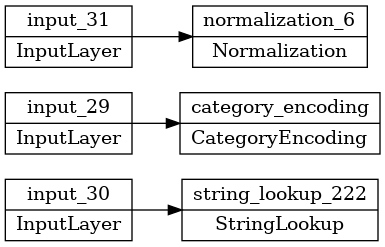

In [664]:
tf.keras.utils.plot_model(preprocessing_model, rankdir = "LR", show_layer_names = True, expand_nested = True)

In [ ]:
inputs = {
  'type': tf.keras.Input(shape=(one_hot_dims,), dtype='float32'),
  'size': tf.keras.Input(shape=(), dtype='int64'),
  'weight': tf.keras.Input(shape=(), dtype='float32'),
}
# Since the embedding is trainable, it needs to be part of the training model.
embedding = tf.keras.layers.Embedding(len(vocab), embedding_dims)
outputs = tf.keras.layers.Concatenate()([
  inputs['type'],
  embedding(inputs['size']),
  tf.expand_dims(inputs['weight'], -1),
])
outputs = tf.keras.layers.Dense(1)(outputs)
training_model = tf.keras.Model(inputs, outputs)

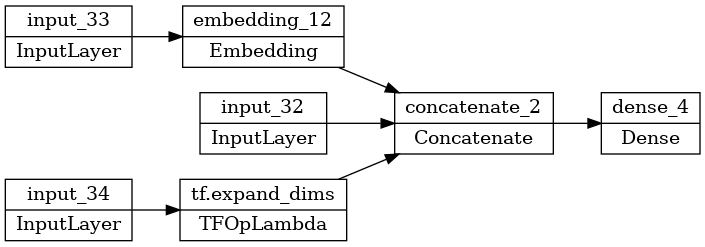

In [663]:
tf.keras.utils.plot_model(training_model, rankdir = "LR", show_layer_names = True, expand_nested = True)

In [ ]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs, outputs)

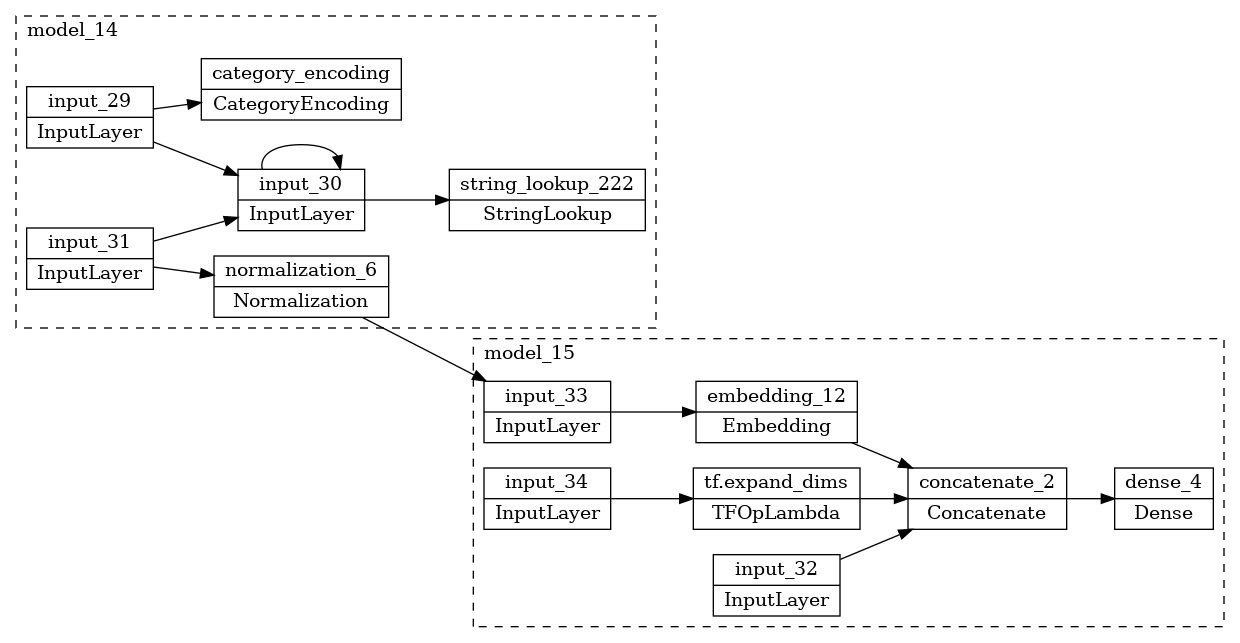

In [662]:
tf.keras.utils.plot_model(inference_model, rankdir = "LR", show_layer_names = True, expand_nested = True)